
Searching for habitable exoplanets
---



### Introduction

In order to find habitable exoplanets data about the planets and their respecitve host stars must be known. The two data files exoplanet_data_2024 and exoplanet_hosts_2024 provide data on:

- **pl_name** , plamet name
- **host name** , host star name
- **pl_orbper** , planet orbital period in days
- **pl_orbsmax** , semi major axis in au
- **pl_rade** , planet radius in multipules of earth radii
- **pl_masse** , planet mass in multiples of earth masses
- **pl_orbincl** , orbital inclination in degrees
- **pl_orbeccen** , orbital eccentricity

- **hostname** , star name
- **st_rad** , star radius
- **st_mass** , star mass in solar masses
- **st_met** , star metallicity in dex
- **st_age** , star age in billions of years
- **sy_dist** , distance to star in parsecs
- **sy_gaiamag** , apparent G-band magnitude in mags

In [3]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import matplotlib
import math

exo_df = pd.read_csv('./data/exoplanet_data_2024.csv')
exoplanets_df = exo_df[['pl_orbsmax','hostname','pl_rade','pl_masse']]

Firstly the exoplanet data is cleaned by selecting specific rows for semi major axis, host star name, planet radius and planet mass. Then a histogram is plotted of the distribution of the semi major axes.

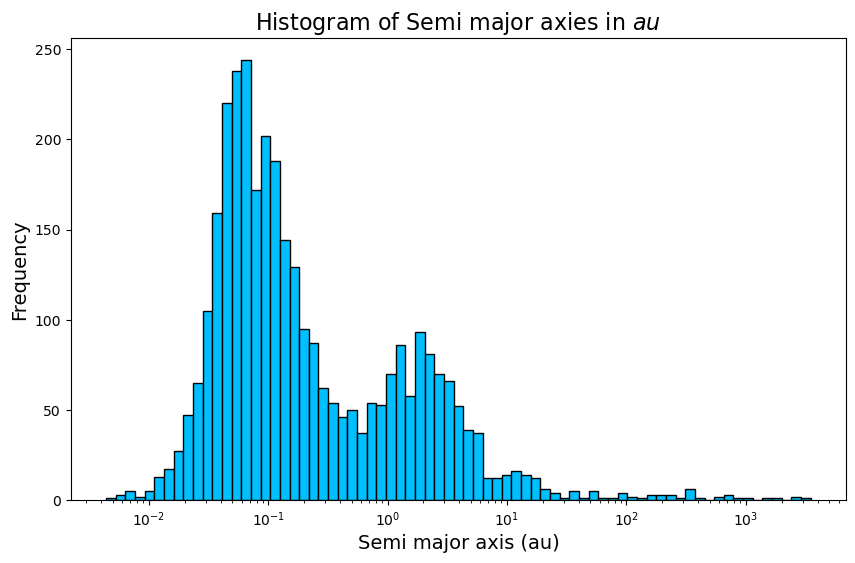

In [5]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

num = len(exoplanets_df['pl_orbsmax'])

sqrt_num = np.sqrt(num)

bins = np.logspace(np.log10(exoplanets_df['pl_orbsmax'].min()),np.log10(exoplanets_df['pl_orbsmax'].max()), int(sqrt_num))

ax.hist(exoplanets_df['pl_orbsmax'], bins, color = 'deepskyblue', edgecolor = 'black')

ax.set_xlabel('Semi major axis (au)', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Histogram of Semi major axies in $au$', fontsize=16)
ax.set_xscale('log')
plt.show()

In [6]:
host_df = pd.read_csv('./data/exoplanet_hosts_2024.csv')
hoststar_df = host_df[['sy_dist','sy_gaiamag','hostname','st_rad']]
hoststar_df = hoststar_df[~hoststar_df.isna().any(axis=1)]
hoststar_df.dropna(inplace=True)

exoplanets_df[~exoplanets_df.isna().any(axis=1)]
exoplanets_df.dropna(inplace=True)

/var/folders/4q/3w93328x26vdhg53m28djjw40000gn/T/ipykernel_1317/1628439126.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exoplanets_df.dropna(inplace=True)


Now the hoststar data is cleaned in a similar way to the exoplanet data. Rows without values for distance to the star system, apparent magnitude, hostname and stellar radius are removed. The Hostname collumn is important as it enables the datasets to be merged later.

### Calculating Luminosity
In order to calculate luminosity of the stars the absolute magnitude must be calculated. The distance modulus equation can be used:
$$\mu = 5 \log_{10} d - 5$$
Then absolute magnitude $M$ can be calculated using:

$M = m - \mu$

Where $m$ is the apparent magnitude and $\mu$ is the distance modulus.

The distanceMod() function will calculate $\mu$ and can be applied to the sy_dist collumn in the data frame.

Once the absolute magnitude is calculated $L$ luminosity can be calculated using the equation:
$$L = 10^{{(M_{0}-M)}/2.5}$$

The Lum() function will calcuate luminosity which can the be applied to the dataframe creating a new collumn 'Luminosity' in the dataframe.

In [9]:
def distanceMod(d):
    return 5 * np.log10(d) - 5
    # -- d = distance to the star --
hoststar_df['mu'] = hoststar_df['sy_dist'].apply(distanceMod)

def AbsMag(apM, mu):
    M = apM - mu 
    # -- M = absoulte magnitude of the star --
    # -- apM = apparent magnitude of the star --
    return M

hoststar_df['M'] = hoststar_df.apply(lambda row: AbsMag(row['sy_gaiamag'], row['mu']), axis=1)

def Lum(M):
    M_0 = 4.68
    L = 10**((M_0 - M)/2.5)
    # -- L = luminosity of the star --  
    return L 

hoststar_df['Luminosity'] = hoststar_df['M'].apply(Lum)

### Calculating the effective temperature of the hoststar

The equation relating Luminosity, temperature and stellar radius is:

$$\dfrac{L}{L_\odot} = \left(\dfrac{R}{R_\odot}\right)^2 \left(\dfrac{T_{eff}}{T_{eff\odot}}\right)^4$$

This equation can be rearranged to give the effective temperature of the star as the subject:

$$T_{eff} = \left(\dfrac{({T_{eff\odot})^4}{L}{R_\odot}^2}{R^2}\right)^{\dfrac{1}{4}}$$

The function T_star() can then be applied to the hoststar_df to create a new column in the data file for effective temperature of the star.

In [11]:
def T_star(Luminosity, Star_Radius):
    R_0   = 1
    T_eff_0 = 7756
    T_eff = (((T_eff_0)**4 * Luminosity * (R_0)**2 )/((Star_Radius)**2))**0.25
    return T_eff

hoststar_df['T_effective'] = hoststar_df.apply(lambda x: T_star(x['Luminosity'], x['st_rad']), axis=1)
hoststar_df.head()

,sy_dist,sy_gaiamag,hostname,st_rad,mu,M,Luminosity,T_effective
0,93.1846,4.44038,11 Com,13.76,4.846721,-0.406341,108.277019,6744.700292
1,125.3210,4.56216,11 UMi,29.79,5.490119,-0.927959,175.058702,5168.904100
2,75.4392,4.91781,14 And,11.55,4.387985,0.529825,45.716203,5934.229599
4,21.1397,6.06428,16 Cyg B,1.13,1.625494,4.438786,1.248779,7712.940633
5,124.9530,4.75429,17 Sco,25.92,5.483733,-0.729443,145.806665,5293.764846


If we look at the data file there are now new columns for luminosity measured in multiples of the suns luminosity and the effective temperature of each star. 

Adding the 'T_effective' column to the 'exoplanets_df' will enable the surface temperature to be calculated later.

In [13]:
exoplanets_df = exoplanets_df.merge(hoststar_df[['hostname', 'T_effective', 'sy_dist']],on='hostname',how='left')
exoplanets_df.head()

,pl_orbsmax,hostname,pl_rade,pl_masse,T_effective,sy_dist
0,0.0370,WASP-91,11.545,425.89220,6546.214390,149.942
1,0.2100,Kepler-289,2.150,7.30000,7678.549496,704.438
2,3.5300,HD 206893,16.365,4036.42077,NaN,NaN
3,0.3553,Kepler-413,4.347,67.00000,6549.974003,847.536
4,0.4660,Kepler-11,3.330,25.00000,7578.746846,646.346


In order to calculate surface temperature of the planets the 'T_effective' must be added to the correct planets of the exoplanets dataframe.

### Calculating planet surface temperature
Since the effective temperature in each star has been calculated the formula:

$$T_p = T_{eff}\left(\dfrac{0.9R}{2\alpha}\right)^\dfrac{1}{2}$$

Is used where $T_p$ is the surface temperature of the planet and $\alpha$ is the semi major axis in $au$.

A new column in the exoplanets data file 'pl_temp' is then created to store all the planet surface temperatures.

In [16]:
def T_planet(T_eff, Radius, a):
    R_e = 6.378e6
    Temp_planet = T_eff * (((0.9 * Radius * R_e) / (2 * a * 1.496e11)) ** 0.5)
    # -- a = semi major axis --
    return Temp_planet

exoplanets_df['pl_temp'] = exoplanets_df.apply(lambda x: T_planet(x['T_effective'], x['pl_rade'], x['pl_orbsmax']), axis = 1)

After some removal of rows that didnt have values for the effective star temperature the exoplanets data file can then be displayed with planet temperatures in kelvin.

In [18]:
exoplanets_df[~exoplanets_df.isna().any(axis=1)]
exoplanets_df.dropna(inplace=True)
exoplanets_df

,pl_orbsmax,hostname,pl_rade,pl_masse,T_effective,sy_dist,pl_temp
0,0.03700,WASP-91,11.545,425.89220,6546.214390,149.9420,506.487870
1,0.21000,Kepler-289,2.150,7.30000,7678.549496,704.4380,107.614672
3,0.35530,Kepler-413,4.347,67.00000,6549.974003,847.5360,100.350493
4,0.46600,Kepler-11,3.330,25.00000,7578.746846,646.3460,88.737926
5,0.06070,WASP-131,13.675,85.81410,8495.334776,200.0750,558.512037
...,...,...,...,...,...,...,...
887,0.02040,WD 1856+534,10.400,4386.05400,7219.409202,24.7359,713.979861
888,0.05053,WASP-189,18.147,632.47853,10356.854756,99.7310,859.683069
889,0.05500,WASP-151,13.305,100.43378,7709.271641,453.0990,525.196908
890,0.33000,Kepler-289,2.680,4.00000,7678.549496,704.4380,95.845634


### Classification of planets

In deciding whether to class a planet as habitable it is a pretty safe assumption that liquid water is one of the factors that should be considered. If the planets surface temperature lies in a certain range it is likely that liquid water exists. Using a temperature range of $258.15K$ to $388.15K$  results in 12.06% of the planets being returned as habitable.

In [20]:
exoplanets_df['Classification'] = exoplanets_df['pl_temp'].apply(lambda x: 'Habitable' if x>=258.15 and x<=388.15 else 'Not Habitable' )
exoplanets_df['Classification'].shape

(854,)

In [21]:
Num_habitable = (exoplanets_df['Classification'] == 'Habitable').sum()
print(Num_habitable/854)

0.12060889929742388


### Mass classification
The planets can then be grouped into 'Earth-like', 'Neptunian' or 'Jovian' meaning either rocky, like netpune like or jupiter like based on their mass measured in multiples of earth masses.

In [23]:
exoplanets_df['Mass_Classification'] = exoplanets_df['pl_masse'].apply(
    lambda x: 'Earth-like' if 0.01 < x < 10
    else 'Neptunian'       if 10   < x < 32
    else 'Jovian'          if 32   < x < 4000
    else 'Unclassified')
exoplanets_df

,pl_orbsmax,hostname,pl_rade,pl_masse,T_effective,sy_dist,pl_temp,Classification,Mass_Classification
0,0.03700,WASP-91,11.545,425.89220,6546.214390,149.9420,506.487870,Not Habitable,Jovian
1,0.21000,Kepler-289,2.150,7.30000,7678.549496,704.4380,107.614672,Not Habitable,Earth-like
3,0.35530,Kepler-413,4.347,67.00000,6549.974003,847.5360,100.350493,Not Habitable,Jovian
4,0.46600,Kepler-11,3.330,25.00000,7578.746846,646.3460,88.737926,Not Habitable,Neptunian
5,0.06070,WASP-131,13.675,85.81410,8495.334776,200.0750,558.512037,Not Habitable,Jovian
...,...,...,...,...,...,...,...,...,...
887,0.02040,WD 1856+534,10.400,4386.05400,7219.409202,24.7359,713.979861,Not Habitable,Unclassified
888,0.05053,WASP-189,18.147,632.47853,10356.854756,99.7310,859.683069,Not Habitable,Jovian
889,0.05500,WASP-151,13.305,100.43378,7709.271641,453.0990,525.196908,Not Habitable,Jovian
890,0.33000,Kepler-289,2.680,4.00000,7678.549496,704.4380,95.845634,Not Habitable,Earth-like


In [24]:
clean_exoplanets_df = exoplanets_df[exoplanets_df['Mass_Classification'] != 'Unclassified']

The unclassified planets are removed which are planets that are over 4000 earth masses and can be classified as sub-brown dwarfs. This results in a new dataframe 'clean_exoplanets_df'

### Calculating density

Using the formila $\rho = \dfrac{M}{V}$ where $\rho$ is the density measured in ${kg}{m^{-3}}$

A new collunm is created in the dataframe 'clean_exoplanets_df' in order to store the average density values.

In [26]:
import math
def AvgDensity(Radius, Mass):
    R_0 = 6.378e6 #radius of earth
    M_0 = 5.972e24 #mass of earth
    D = ((Mass * M_0) / ((4/3)*(math.pi)*(Radius * R_0)**3))
    # D = Density in Kg/m^3
    return(D)

clean_exoplanets_df.loc[:,'Average_Density'] = clean_exoplanets_df.apply(lambda x: AvgDensity(x['pl_rade'], x['pl_masse']), axis = 1)

/var/folders/4q/3w93328x26vdhg53m28djjw40000gn/T/ipykernel_1317/3548179450.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_exoplanets_df.loc[:,'Average_Density'] = clean_exoplanets_df.apply(lambda x: AvgDensity(x['pl_rade'], x['pl_masse']), axis = 1)


### Plotting planet mass vs average density

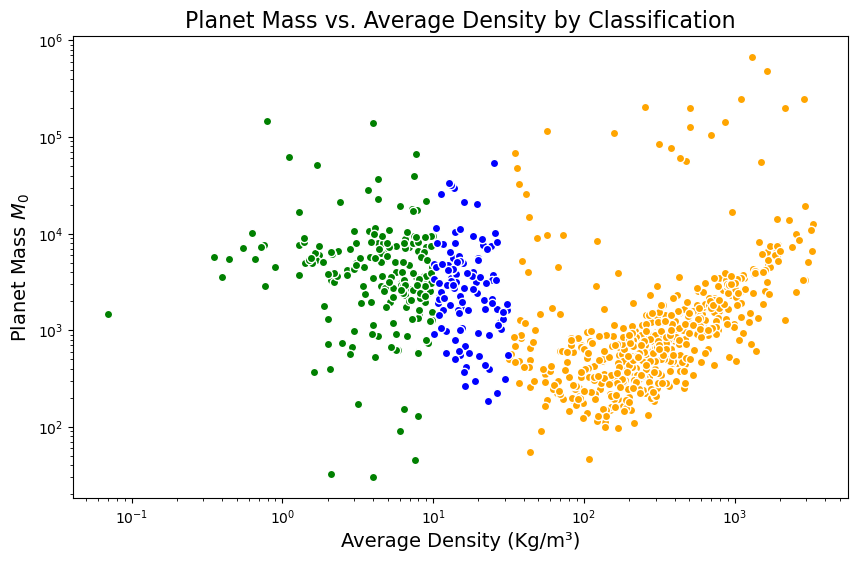

In [28]:
fig = plt.figure(figsize=(10,6))
ax  = fig.add_subplot(1,1,1)
categories = clean_exoplanets_df['Mass_Classification'].unique()
colors = {'Jovian': 'orange', 'Earth-like': 'green' , 'Neptunian': 'blue'}
symbols = {'Jovian': 'o', 'Earth-like': 'o' , 'Neptunian': 'o'}

for category in categories:
    subset = clean_exoplanets_df[clean_exoplanets_df['Mass_Classification'] == category]
    ax.scatter(subset['pl_masse'],subset['Average_Density'],c=colors[category],edgecolors = 'w',label=category,marker=symbols[category])

ax.set_xlabel('Average Density (Kg/m³)', fontsize = 14)
ax.set_ylabel('Planet Mass $M_0$', fontsize = 14)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('Planet Mass vs. Average Density by Classification', fontsize=16)
plt.show()

### Plotting distance from earth vs average density

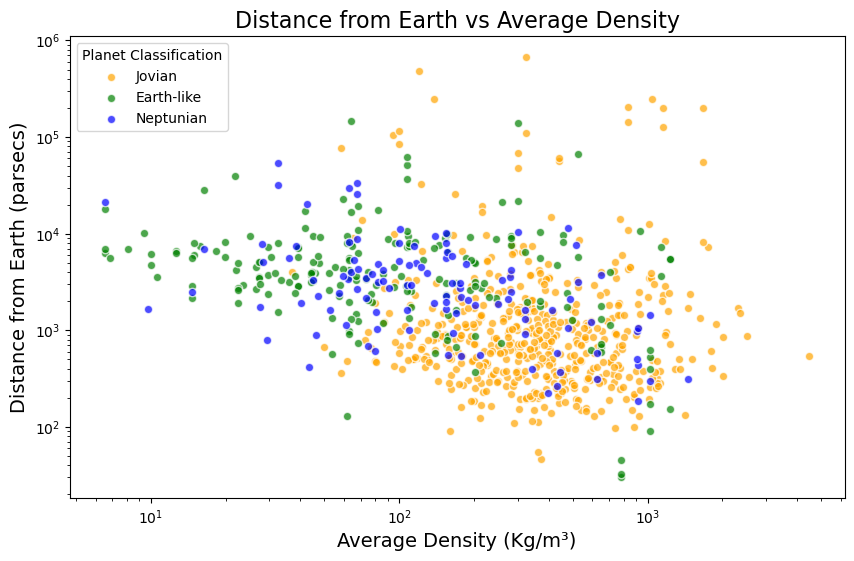

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
categories = clean_exoplanets_df['Mass_Classification'].unique()

colors = {'Jovian': 'orange', 'Earth-like': 'green' , 'Neptunian': 'blue'}
symbols = {'Jovian': 'o', 'Earth-like': 'o' , 'Neptunian': 'o'}

for category in categories:
    subset = clean_exoplanets_df[clean_exoplanets_df['Mass_Classification'] == category]
    ax.scatter(subset['sy_dist'],subset['Average_Density'],c=colors[category],label=category,alpha=0.7,edgecolors='w',marker=symbols[category])

ax.set_ylabel('Distance from Earth (parsecs)', fontsize=14)
ax.set_xlabel('Average Density (Kg/m³)', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Distance from Earth vs Average Density', fontsize=16)
ax.legend(title='Planet Classification', loc='best')
plt.show()

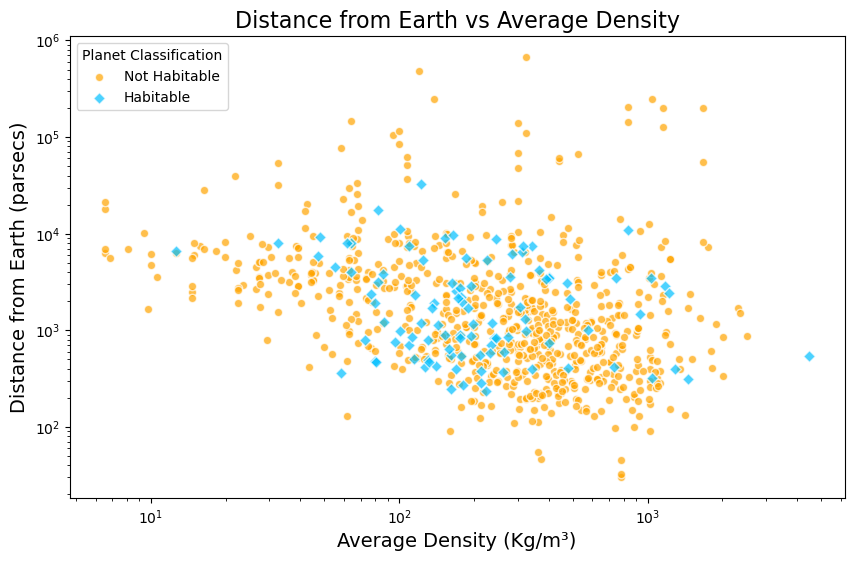

In [61]:
fig, ax = plt.subplots(figsize=(10, 6))
categories = clean_exoplanets_df['Classification'].unique()

colors = {'Not Habitable': 'orange', 'Habitable': 'deepskyblue'}
symbols = {'Not Habitable': 'o', 'Habitable': 'D'}

for category in categories:
    subset = clean_exoplanets_df[clean_exoplanets_df['Classification'] == category]
    ax.scatter(subset['sy_dist'],subset['Average_Density'],c=colors[category],label=category,alpha=0.7,edgecolors='w',marker=symbols[category])

ax.set_ylabel('Distance from Earth (parsecs)', fontsize=14)
ax.set_xlabel('Average Density (Kg/m³)', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Distance from Earth vs Average Density', fontsize=16)
ax.legend(title='Planet Classification', loc='best')
plt.show()

In [32]:
habitable_df = clean_exoplanets_df[clean_exoplanets_df['Classification'] == 'Habitable']

In [33]:
second_earth_df = habitable_df[habitable_df['Mass_Classification'] == 'Earth-like']
second_earth_df.head(15)

,pl_orbsmax,hostname,pl_rade,pl_masse,T_effective,sy_dist,pl_temp,Classification,Mass_Classification,Average_Density
112,0.01800,HD 20329,1.720,7.42,7481.862835,63.6796,320.346830,Habitable,Earth-like,8013.019684
197,0.01661,HD 80653,1.613,5.72,8019.451818,109.8600,346.146359,Habitable,Earth-like,7489.806049
211,0.00936,K2-131,1.690,7.90,6590.050475,152.5090,387.861691,Habitable,Earth-like,8993.828926
232,0.02085,HD 93963 A,1.350,7.80,8008.644224,82.3432,282.264053,Habitable,Earth-like,17420.914217
277,0.02636,TOI-969,2.765,9.10,5779.560600,77.2554,259.270082,Habitable,Earth-like,2365.558162
365,0.00901,Kepler-78,1.201,1.68,6525.374801,124.3760,329.987347,Habitable,Earth-like,5329.149509
427,0.01900,TOI-1416,1.620,3.48,6513.357151,55.0135,263.431871,Habitable,Earth-like,4497.921228
451,0.01130,TOI-431,1.280,3.07,6356.307742,32.5686,296.314836,Habitable,Earth-like,8044.260232
485,0.01544,55 Cnc,1.875,7.99,7047.516650,12.5855,340.169848,Habitable,Earth-like,6660.711270
572,0.01685,Kepler-10,1.470,3.26,7713.541994,185.5060,315.569688,Habitable,Earth-like,5639.534280


Filtering the data frame for Habitable and Earth-like leaves 15 results which are the most likely candidates for a second earth.
Defining a new function for surface gravity measured in multiples of earth's gravity will provide more information on which of the 15 most likely planets is most habitable.

In [35]:
def SurfaceGrav(Mass, Radius):
    R_0 = 6.378e6
    M_0 = 5.972e24
    G   = 6.6743e-11
    # - G is the gravitational constant - 
    g = ( (G * M_0 * Mass) / ((Radius * R_0) ** 2) )
    return (g / 9.81)

In [36]:
second_earth_df.loc[:, 'Surface_Gravity'] = second_earth_df.apply(lambda x: SurfaceGrav(x['pl_masse'], x['pl_rade']), axis = 1)
second_earth_df.loc[:, 'pl_temp'] = second_earth_df['pl_temp'].apply(lambda x: x - 273.15)
second_earth_df[['Surface_Gravity' ,'sy_dist','pl_rade','pl_masse','pl_temp','hostname']]

/var/folders/4q/3w93328x26vdhg53m28djjw40000gn/T/ipykernel_1317/1408005268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_earth_df.loc[:, 'Surface_Gravity'] = second_earth_df.apply(lambda x: SurfaceGrav(x['pl_masse'], x['pl_rade']), axis = 1)


,Surface_Gravity,sy_dist,pl_rade,pl_masse,pl_temp,hostname
112,2.505154,63.6796,1.720,7.42,47.196830,HD 20329
197,2.195911,109.8600,1.613,5.72,72.996359,HD 80653
211,2.762747,152.5090,1.690,7.90,114.711691,K2-131
232,4.274788,82.3432,1.350,7.80,9.114053,HD 93963 A
277,1.188882,77.2554,2.765,9.10,-13.879918,TOI-969
365,1.163351,124.3760,1.201,1.68,56.837347,Kepler-78
427,1.324453,55.0135,1.620,3.48,-9.718129,TOI-1416
451,1.871569,32.5686,1.280,3.07,23.164836,TOI-431
485,2.270031,12.5855,1.875,7.99,67.019848,55 Cnc
572,1.506851,185.5060,1.470,3.26,42.419688,Kepler-10


## Conclusions

Filtering the data frame further so that only Earth-like habitable planets are selected only 15 planets are returned. After calculating values for surface gravity most planets have surface gravity that is twice the strength of the earths surface gravity. This makes these options unusable as the increased gravity will have adverse health effected on any would be inhabitants. rilling out any planets which have a surface gravity over 1.5 times the earths surface gravity reduces the selection further. Of the remaining planets TOI-561 looks like a good candidate with a good value for surface gravity however with a estimated surface temperature $95.6^{\circ}$ life would only be habitable on the poles where the temperautre would be more mild.

A better candidate is TOI-969 with a surface gravity of $1.18g$ and a much more managable surface temperature of $-13.9^{\circ}$. TOI-1416 is also a more ideal candidate with a surface gravity of $1.32g$ and a surface temperature of $-9.7^{\circ}$. Both planets are also within 100 parsecs. This is still a huge distance to cover and this is also without considering whether these planets are tidally locked and the fact that the planets are much bigger than earth in terms of mass and physical size.